In [2]:
import numpy as np
from scipy import signal

In [28]:
class Layer:
    def forward(self, input):
        pass

    def backward(self, grad_output,lr):
        pass

In [29]:
class Dense(Layer):
    def __init__(self, inp, out):
        self.weight = np.random.randn(out, inp) * 0.1
        self.bias = np.zeros((out, 1))

    def forward(self, inp):
        self.inp = inp
        return np.dot(self.weight, self.inp) + self.bias
    def backward(self, out_grad, lr):
        weight_grad = np.dot(out_grad, self.inp.T)
        inp_grad = np.dot(self.weight.T, out_grad)
        self.weight -= lr * weight_grad
        self.bias -= lr * out_grad
        return inp_grad

In [30]:
class Convutional_Layer(Layer):
    def __init__(self, inp_shape, kernel_size, depth):
        inp_depth, inp_height, inp_width = inp_shape
        self.depth = depth
        self.input_shape = inp_shape = inp_shape
        self.inp_depth = inp_depth
        self.out_shape = (depth, inp_height - kernel_size + 1, inp_width - kernel_size +1)
        self.kernels_shape= (depth, inp_depth, kernel_size, kernel_size)
        self.kernels = np.random.rand(*self.kernels_shape)
        self.biases = np.random.rand(*self.out_shape)
    def forward(self,inp):
        self.inp = inp
        self.out = np.copy(self.biases)
        for i in range(self.depth):
            for j in range(self.inp_depth):
                self.out[i] += signal.correlate2d(self.inp[j], self.kernels[i,j], "valid")
        return self.out
    def backprop(self, out_grad, lr):
        kernels_grad = np.zeros(self.kernels_shape)
        inp_grad = np.zeros(self.inp_shape)
        for i in range(self.depth):
            for j in range(self.inp_depth):
                kernels_grad[i,j] = signal.correlate2d(self.input[j], out_grad[i], "valid")
                inp_grad[j] += signal.convolve2d(out_grad[i], self.kernels[i,j], "full")
        self.kernels -= lr*kernels_grad
        self.biases -= lr*out_grad
        return inp_grad

In [31]:
class Reshape(Layer):
    def __init__(self, inp, out):
        self.inp_shape = inp
        self.out_shape = out
    def forward(self, inp):
        return np.reshape(inp, self.out_shape)
    def backward(self, out_grad,lr):
        return np.reshape(out_grad, self.inp_shape)

In [32]:
def BCE(y_true, y_pred):
    return -np.mean(y_true*np.log(y_pred) + (1 - y_true)*np.log(1-y_pred))
def BCE_der(y_true, y_pred):
    return ((1-y_true)/(1-y_pred)-y_true/ y_pred)/ np.size(y_true)

In [33]:
class Activatoo(Layer):
    def __init__(self, act, act_der):
        self.act = act
        self.act_der = act_der
    def forward(self, inp):
        self.inp = inp
        return self.act(self.inp)
    def backward(self, out_grad, lr):
        return out_grad * self.act_der(self.inp)

In [34]:
class Sigmoid(Activatoo):
    def __init__(self):
        def sigmoid(x):
            return 1/(1+np.exp(-x))
        def sigmoid_der(x):
            return sigmoid(x)*(1-sigmoid(x))
        super().__init__(sigmoid, sigmoid_der)

In [37]:
import numpy as np
from torchvision.datasets import FashionMNIST
train = FashionMNIST(root="data", train=True, download=False)
test  = FashionMNIST(root="data", train=False, download=False)
x_train, y_train = train.data.numpy(), train.targets.numpy()
x_test,  y_test  = test.data.numpy(),  test.targets.numpy()
a, b = 0, 1
mask_tr = (y_train == a) | (y_train == b)
mask_te = (y_test  == a) | (y_test  == b)
x_train, y_train = x_train[mask_tr], (y_train[mask_tr] == b).astype(np.float32)
x_test,  y_test  = x_test[mask_te],  (y_test[mask_te]  == b).astype(np.float32)
x_train = (x_train / 255.0).reshape(-1, 1, 28, 28)
x_test  = (x_test  / 255.0).reshape(-1, 1, 28, 28)
x_train=x_train[:200]
y_train=y_train[:200]
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)


(200, 1, 28, 28) (200,)
(2000, 1, 28, 28) (2000,)


In [40]:
network=[
Convutional_Layer((1,28,28),3,2),
Sigmoid(),
Reshape((2,26,26),(2*26*26,1)),
Dense(2*26*26,20),
Sigmoid(),
Dense(20,1),
Sigmoid()
]
epochs=5
lr=0.01
for e in range(epochs):
    loss=0
    for x,y in zip(x_train,y_train):
        y=y.reshape(1,1)
        out=x
        for l in network:
            out=l.forward(out)
        loss+=BCE(y,out)
        grad=BCE_der(y,out)
        for l in reversed(network):
            grad=l.backward(grad,lr)
    print(f"{e+1}/{epochs} {loss/len(x_train)}")
for i,(x,y) in enumerate(zip(x_test[:10],y_test[:10])):
    out=x
    for l in network:
        out=l.forward(out)
    pred=int(out.item()>0.5)
    print(f"{i:02d} pred={pred} actual={int(y.item())}")

1/5 0.6902938121669341
2/5 0.6713661326699749
3/5 0.6432186938653259
4/5 0.6001054325419183
5/5 0.543915288807409
00 pred=1 actual=1
01 pred=1 actual=1
02 pred=1 actual=1
03 pred=1 actual=1
04 pred=0 actual=0
05 pred=1 actual=1
06 pred=1 actual=0
07 pred=0 actual=0
08 pred=1 actual=1
09 pred=1 actual=1


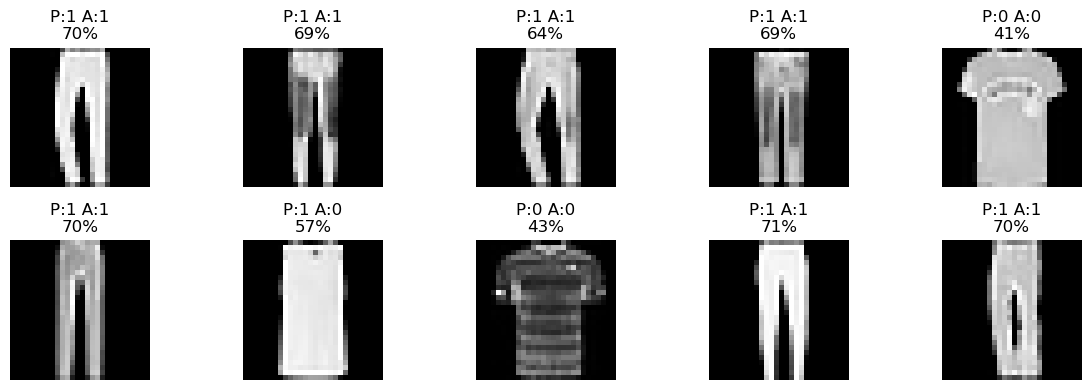

In [46]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
for i,(x,y) in enumerate(zip(x_test[:10],y_test[:10])):
    out=x
    for l in network:
        out=l.forward(out)
    p=out.item()
    pred=int(p>0.5)
    plt.subplot(2,5,i+1)
    plt.imshow(x[0],cmap="gray")
    plt.axis("off")
    plt.title(f"P:{pred} A:{int(y.item())}\n{int(p*100)}%");
plt.tight_layout()
plt.show()
